**Bu notebook sadece sergi amaçlıdır. Tezimin bir parçası olan akustik veri analizi çalışmalarından sadece bir denemenin demosudur.**

**Portfolyo amaçlı paylaşılmaktadır...**


---


**This notebook is for demostration purposes only. It is just a demo of one of my experiments from the acoustic data analysis studies that are part of my thesis.**

**Shared for portfolio purposes...**


---



**Bu çalışmada: daha önce belirli videolardan .wav dosyalarına oradan da MelFraquenctCepstral Coeffients segmentasyonu yapılmış görselleştirilmiş ses veri kullanılmıştır.**

**Çalışmada kullanılan sesler bir çok Psikoterapide danışan bireylerin ifadeleridir. Vokal ifadelerin etiketlenmesi davranış değişim kodlamalarına uygun olarak uzmanlar tarafından yapılmıştır.**

**Bu demo çalışmada akustik veri üzerinden davranış kodu sınıflandırıcısı derlenmektedir.**


---


**In this study: previously visualized audio data was used, which was segmented from certain videos to .wav files and then MelFraquenctCepstral Coefficients (MFCC).**

**The sounds used in the study are the expressions of many individuals who have been counseled in Psychotherapy. The labeling of the vocal expressions was done by experts in accordance with behavioral change coding.**

**In this demo study, a behavioral code classifier is compiled from acoustic data.**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

mfcc_dir = "/content/drive/MyDrive/model/ses_dosyaları/sesler/mfcc_segments"
classes = os.listdir(mfcc_dir)
print("Sınıflar:", classes)


Sınıflar: ['neutral', 'sustain', 'change']


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter

X = []
y = []

for label in classes:
    class_dir = os.path.join(mfcc_dir, label)
    for fname in os.listdir(class_dir):
        if fname.endswith(".npy"):
            fpath = os.path.join(class_dir, fname)
            mfcc = np.load(fpath)
            X.append(mfcc)
            y.append(label)

print(f"Toplam örnek sayısı: {len(X)}")


Toplam örnek sayısı: 6512


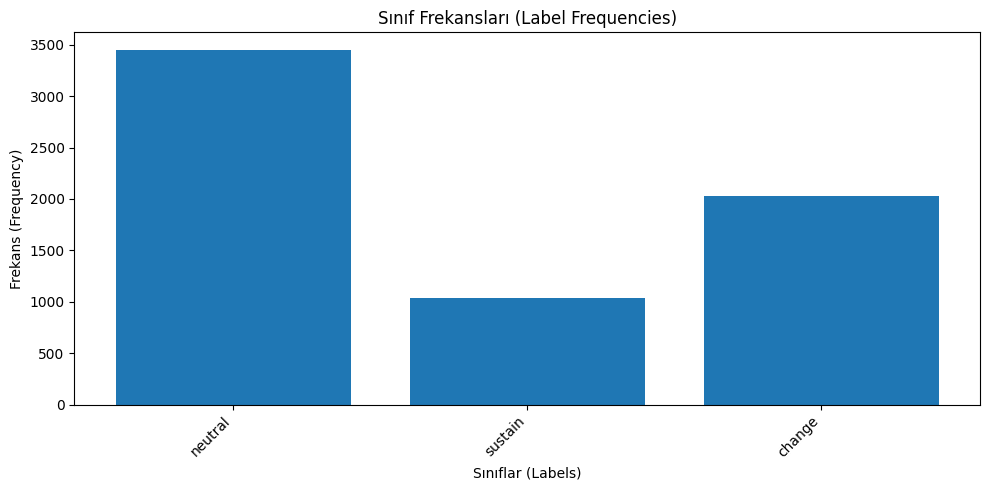

In [ ]:
# Count the frequency of each element in 'y'
frequency_data = Counter(y)

# Extract labels and their frequencies
labels = list(frequency_data.keys())
frequencies = list(frequency_data.values())

# Create the bar chart
plt.figure(figsize=(10, 5))  # Adjust figure size as needed
plt.bar(labels, frequencies)
plt.xlabel("Sınıflar (Labels)")
plt.ylabel("Frekans (Frequency)")
plt.title("Sınıf Frekansları (Label Frequencies)")
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels if needed
plt.tight_layout()
plt.show()

In [ ]:
import os
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [ ]:
# --- Etiket encode ---
le = LabelEncoder()
y_encoded = le.fit_transform(y)

#  Tüm veri
X_train, X_temp, y_train, y_temp = train_test_split(
X, y_encoded, test_size=0.30, stratify=y_encoded, random_state=42)

# Kalan %30 → %15 val, %15 test
X_val, X_test, y_val, y_test = train_test_split(
X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

# ✔️ Kontrol
print("Train:", len(X_train), Counter(y_train))
print("Val  :", len(X_val), Counter(y_val))
print("Test :", len(X_test), Counter(y_test))

Train: 4558 Counter({np.int64(1): 2413, np.int64(0): 1420, np.int64(2): 725})
Val  : 977 Counter({np.int64(1): 518, np.int64(0): 304, np.int64(2): 155})
Test : 977 Counter({np.int64(1): 517, np.int64(0): 305, np.int64(2): 155})


In [ ]:
from imblearn.over_sampling import RandomOverSampler

# her bir gözlemi flatten yaparak tek bir satır/sütunda temsil ediyoruz: ki oversampling yapabilelim.
X_train_flat = [x.flatten() for x in X_train]
ros = RandomOverSampler(random_state=42)
X_resampled_flat, y_resampled = ros.fit_resample(X_train_flat, y_train)

print("Oversampled Train dağılımı:", Counter(y_resampled))

Oversampled Train dağılımı: Counter({np.int64(1): 2413, np.int64(0): 2413, np.int64(2): 2413})


In [ ]:
for i, class_name in enumerate(le.classes_):
    print(f"{i} → {class_name}")

0 → change
1 → neutral
2 → sustain


In [ ]:
# Flattining'den sonra tekrar orijinal MFCC şekline çeviriyoruz
# İlk örneğin shape'ini referans aldık
n_frames, n_coeffs = X_train[0].shape
X_resampled = [np.reshape(vec, (n_frames, n_coeffs)) for vec in X_resampled_flat]
# MFCC :shape (frame, 13) # 13 MFCC extration edilmişti. Bazı çalışmalar 40 öneriyor. İnsan sesi için 13 yeterli

In [ ]:
# Padding için lenght alıyoruz
def get_max_frame(X_sets):
    return max([x.shape[0] for x in X_sets])

max_len = max([
    get_max_frame(X_resampled),
    get_max_frame(X_val),
    get_max_frame(X_test)
])

print(f"Frame sayısı için ortak uzunluk (padding): {max_len}")

Frame sayısı için ortak uzunluk (padding): 157


In [ ]:
def pad_mfcc_list(X_list, max_len):
    padded = [
        np.pad(x, ((0, max_len - x.shape[0]), (0, 0))) if x.shape[0] < max_len else x
        for x in X_list
    ]
    return np.stack(padded)


In [ ]:
X_train_array = pad_mfcc_list(X_resampled, max_len)
X_val_array   = pad_mfcc_list(X_val, max_len)
X_test_array  = pad_mfcc_list(X_test, max_len)


In [ ]:
X_train_array = X_train_array[..., np.newaxis]  # (sample, time, mfcc, 1)
X_val_array   = X_val_array[..., np.newaxis]
X_test_array  = X_test_array[..., np.newaxis]


In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_resampled)
y_val_cat   = to_categorical(y_val)
y_test_cat  = to_categorical(y_test)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization


In [ ]:
num_classes = y_train_cat.shape[1]

In [ ]:
model = Sequential([
    tf.keras.layers.Input(shape=(max_len, 13, 1)),

    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    #Dropout(0.3),
    BatchNormalization(),

    Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),
    BatchNormalization(),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [ ]:
import tensorflow as tf
from tensorflow.keras import backend as K

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=1)
        y_pred = tf.argmax(y_pred, axis=1)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * (precision * recall) / (precision + recall + K.epsilon())

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        F1Score(name='f1')
    ]
)


In [ ]:
history = model.fit(
    X_train_array, y_train_cat,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_array, y_val_cat),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)


Epoch 1/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.3899 - f1: 0.6929 - loss: 1.4008 - val_accuracy: 0.4790 - val_f1: 0.5374 - val_loss: 1.0327
Epoch 2/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4409 - f1: 0.6943 - loss: 1.0577 - val_accuracy: 0.4237 - val_f1: 0.7575 - val_loss: 1.0653
Epoch 3/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4661 - f1: 0.7106 - loss: 1.0253 - val_accuracy: 0.4504 - val_f1: 0.7352 - val_loss: 1.0473
Epoch 4/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4940 - f1: 0.7333 - loss: 1.0015 - val_accuracy: 0.4299 - val_f1: 0.7634 - val_loss: 1.0752
Epoch 5/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5423 - f1: 0.7550 - loss: 0.9429 - val_accuracy: 0.4678 - val_f1: 0.6883 - val_loss: 1.0093
Epoch 6/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5821 - f1: 0.7826 - loss: 0.8809 - val_accuracy: 0.4893 - val_f1: 0.7003 - val_loss: 0.9967
Epoch 7/100
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 

<Axes: >

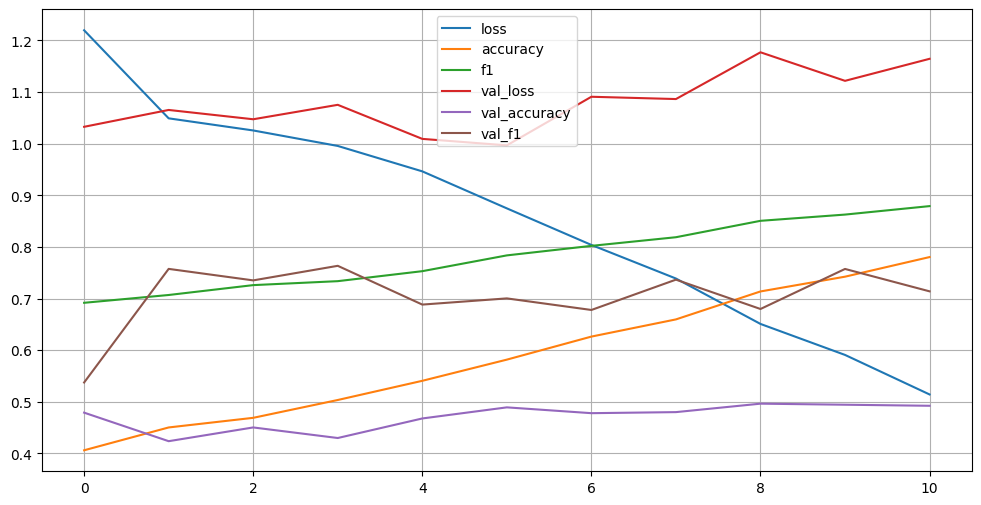

In [ ]:
import pandas as pd

df = pd.DataFrame(history.history)
df[['loss', 'accuracy', 'f1', 'val_loss', 'val_accuracy', 'val_f1']].plot(figsize=(12,6), grid=True)




*   ÖZellikle 40. epoch civarından itibaren Overfitting görünüyor
*   Train set dengeli ancak val set dengesiz. Dengesiz veri seti üzerinde tahminlemede f1 fena değil.
*   Tüm iterasyonlar boyunca val_acc hafif iyileşme göstermiş. 40 epoch civarı kafi olacaktır.





In [ ]:
y_pred_probs = model.predict(X_test_array)
y_pred = tf.argmax(y_pred_probs, axis=1).numpy()
y_true = tf.argmax(y_test_cat, axis=1).numpy()


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


Test için ayırdığım bir diğer val seti tedbir amaçlı tekrar tahminliyorum. Confussion Matrix nihai yorumu yapmamızı sağlayacak

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Test Set Sınıflandırma Raporu:")
print(classification_report(y_true, y_pred, target_names=le.classes_))


Test Set Sınıflandırma Raporu:
              precision    recall  f1-score   support

      change       0.38      0.47      0.42       305
     neutral       0.64      0.50      0.56       517
     sustain       0.19      0.25      0.22       155

    accuracy                           0.45       977
   macro avg       0.40      0.40      0.40       977
weighted avg       0.49      0.45      0.46       977



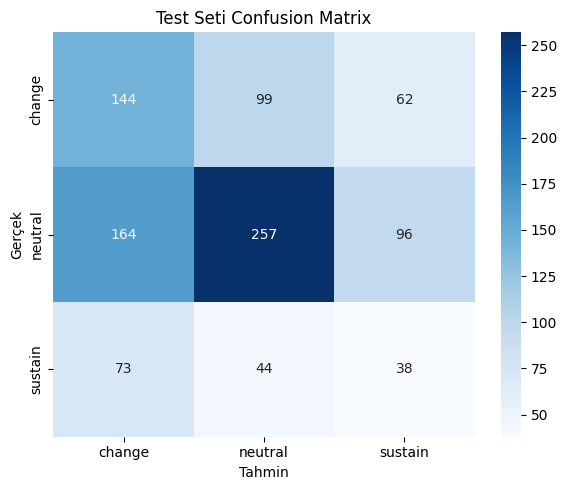

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_,
            yticklabels=le.classes_)
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Test Seti Confusion Matrix")
plt.tight_layout()
plt.show()


Konuşmaların doğası gereği "neutral" ifadeler baskın bir şekilde "change" ve "sustain" ifadelerden fazla gözlenmektedir. Bu sebeple sınıflandırmadık bias aslıda doğal görünmektedir. Ancak Terapilerde aslolan "sustain" ya da "change" i doğru yakalayıp ona göre terapi stratejisi geliştirmektir.

Bu alanda yapılan Türkiye'deki az sayıda çalışma için umut verici bir sonuç aldık.

Ancak teknik olarak canlıya alınması mümkün görünmemektedir. Özellikle veride iyi bir geliştirme yapılmalıdır.

In [ ]:
model.save("/content/drive/MyDrive/model/ses_mfcc_CNN2d_model/ses_siniflandirma_modeli.h5")


In [ ]:
from tensorflow.keras.models import load_model

# F1 metriğini yeniden tanımla
model = load_model("/content/drive/MyDrive/model/ses_mfcc_CNN2d_model/ses_siniflandirma_modeli.h5",
                   custom_objects={"F1Score": F1Score})
